<a href="https://colab.research.google.com/github/rezahamzeh69/UNSW-NB15-Cybersecurity-Attack-Detection-Using-Deep-Learning/blob/main/Transformer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU acceleration enabled.
Epoch 1/50
71/71 - 11s - 153ms/step - accuracy: 0.7524 - auc_5: 0.8258 - loss: 1.1230 - val_accuracy: 0.2789 - val_auc_5: 0.0000e+00 - val_loss: 1.3604 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 - 0s - 5ms/step - accuracy: 0.8575 - auc_5: 0.9258 - loss: 0.8869 - val_accuracy: 0.3481 - val_auc_5: 0.0000e+00 - val_loss: 1.3664 - learning_rate: 1.0000e-04
Epoch 3/50
71/71 - 1s - 9ms/step - accuracy: 0.8767 - auc_5: 0.9463 - loss: 0.7993 - val_accuracy: 0.4297 - val_auc_5: 0.0000e+00 - val_loss: 1.2670 - learning_rate: 1.0000e-04
Epoch 4/50
71/71 - 1s - 9ms/step - accuracy: 0.8832 - auc_5: 0.9554 - loss: 0.7451 - val_accuracy: 0.5027 - val_auc_5: 0.0000e+00 - val_loss: 1.1338 - learning_rate: 1.0000e-04
Epoch 5/50
71/71 - 0s - 5ms/step - accuracy: 0.8921 - auc_5: 0.9632 - loss: 0.6924 - val_accuracy: 0.5771 - val_auc_5: 0.0000e+00 - val_loss: 1.0338 - learning_rate: 1.0000e-04
Epoch 6/50
71/71 - 0s - 5ms/step - accuracy: 0.8972 - auc_5: 0.9682 - loss: 0.6519 - v

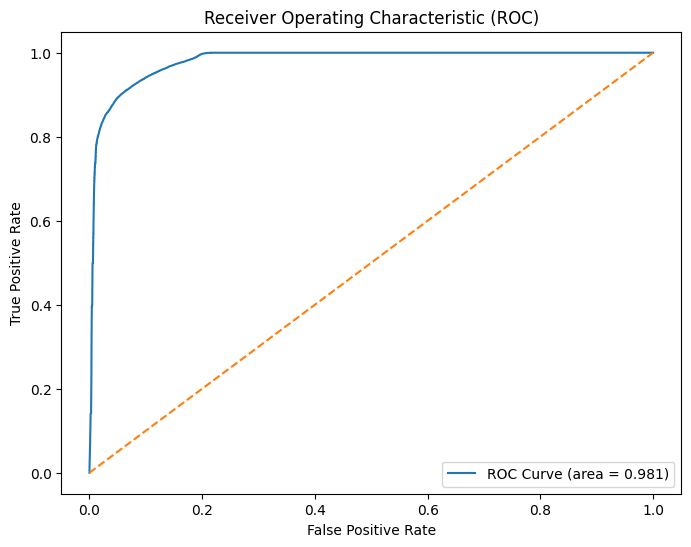

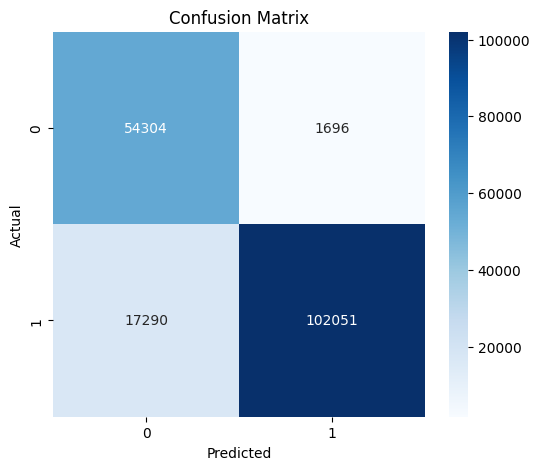

Optimized model saved.


In [15]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

train_file = "UNSW_NB15_training-set.csv"
test_file = "UNSW_NB15_testing-set.csv"

if not (os.path.exists(train_file) and os.path.exists(test_file)):
    from google.colab import files
    uploaded = files.upload()

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

numeric_features = ['dur','spkts','dpkts','sbytes','dbytes','rate','sttl','dttl',
                    'sload','dload','sloss','dloss','sinpkt','dinpkt','sjit','djit',
                    'swin','stcpb','dtcpb','dwin','tcprtt','synack','ackdat','smean',
                    'dmean','trans_depth','response_body_len','ct_srv_src','ct_state_ttl',
                    'ct_dst_ltm','ct_src_dport_ltm','ct_dst_sport_ltm','ct_dst_src_ltm',
                    'is_ftp_login','ct_ftp_cmd','ct_flw_http_mthd','ct_src_ltm','ct_srv_dst']
categorical_features = ['proto', 'service', 'state']

scaler = StandardScaler()
train_data[numeric_features] = scaler.fit_transform(train_data[numeric_features])
test_data[numeric_features] = scaler.transform(test_data[numeric_features])

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
train_encoded = encoder.fit_transform(train_data[categorical_features])
test_encoded = encoder.transform(test_data[categorical_features])

X_train = np.hstack([train_data[numeric_features], train_encoded])
X_test = np.hstack([test_data[numeric_features], test_encoded])
y_train = train_data['label']
y_test = test_data['label']

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

def configure_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU acceleration enabled.")
        except RuntimeError as e:
            print(e)

configure_gpu()

def build_model(input_shape):
    inputs = layers.Input(shape=(input_shape,))
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

input_shape = X_train.shape[1]
model = build_model(input_shape)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=1024,
                    validation_split=0.2, callbacks=callbacks, verbose=2)

results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}, Test Accuracy: {results[1]*100:.2f}%, Test AUC: {results[2]:.3f}")

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test F1-Score: {f1:.3f}, Test ROC-AUC: {roc_auc:.3f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

model.save("UNSW_NB15_Final_Model.keras")
print("Optimized model saved.")
